In [1]:
import os
os.environ["THEANO_FLAGS"] = "device=gpu0"
os.environ["CPATH"] = ""
import numpy as np

from collections import OrderedDict
from lasagnekit.misc.draw_net import draw_to_notebook, draw_to_file
from lasagnekit.misc.plot_weights import grid_plot
from lasagnekit.misc.dream import build_dreamer
from lasagnekit.easy import LightweightModel, BatchOptimizer
from lasagnekit.generative.capsule import Capsule
from lasagnekit.easy import BatchIterator, get_batch_slice


from lasagnekit.datasets.mnist import MNIST
from lasagnekit.datasets.fonts import Fonts
from lasagnekit.datasets.rescaled import Rescaled
from lasagnekit.datasets.dtd import DTD
from lasagnekit.datasets.cached import Cached

from lasagne import layers, updates
from IPython.display import SVG

import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams


srng = RandomStreams(seed=234)


from skimage.io import imread
from skimage.transform import resize

from lasagnekit.easy import get_stat

import matplotlib.pyplot as plt

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax, rectify
from lasagne.init import GlorotUniform, Constant
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

from utils import TransposedConv2DLayer, Conv2DDenseLayer

%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K20m (CNMeM is disabled)


In [3]:
seed = 1234
np.random.seed(seed)
rng = RandomStreams(seed)

In [4]:
# choose between mnist and fonts
dataset = "textures"
w, h = 28, 28 # Desired resolution, not necessarely the same than real_w and real_h, 
              # if necessary the images will be resize to fit w and h)

In [5]:
if dataset == "mnist":
    data = MNIST()
elif dataset == "fonts":
    data = Fonts(kind="all_64", 
                 labels_kind="letters")
elif dataset == "textures":
    data = DTD(filter_by=lambda x:np.random.choice(x, size=2000, replace=False))
    data.load()
data_rescaled = Rescaled(data, size=(w, h), cache=True)
data_rescaled.load()
X = data_rescaled.X
y = data_rescaled.y

In [ ]:
input_images_ = input_images.transpose((0, 2, 3, 1))

if input_images_.shape[-1] == 1:
    input_images_ = input_images_[:, :, :, 0]
    
fig = plt.figure(figsize=(10, 10))
n = 5
gridw, gridh = n, n
k = 1
ind = 0
for i in range(n):
    for j in range(n):
        plt.subplot(gridw, gridh, k)
        plt.axis('off')
        plt.imshow(input_images_[ind], cmap="gray")
        k += 1
        ind += 1
plt.show()

In [6]:
if len(data_rescaled.img_dim) == 3:
    nb_colors = data_rescaled.img_dim[0]
else:
    nb_colors = 1 # gray

In [7]:
print(X.shape, y.shape,)

((2000, 2352), (2000,))


In [8]:
X = X.reshape((X.shape[0], nb_colors, w, h))

In [9]:
X, y = shuffle(X, y)
train, test = train_test_split(range(X.shape[0]), test_size=0.25)

# Model

In [10]:
class Model(object):
    
    def get_all_params(self, **kwargs):
        return list(set(self.x_to_z.get_all_params(**kwargs) + 
                        self.z_to_x.get_all_params(**kwargs)))

In [11]:
model_type = "convnet"

In [12]:
if model_type == "fully_connected":
    ## fully connected
    latent_size = 20
    num_hidden_units = 1000

    l_in = layers.InputLayer((None, nb_colors, w, h), name="input")

    l_encoder1 = layers.DenseLayer(l_in, num_units=num_hidden_units)
    l_encoder2 = layers.DenseLayer(l_encoder1, num_units=num_hidden_units)
    l_encoder3 = layers.DenseLayer(l_encoder2, num_units=num_hidden_units)
    
    l_latent = layers.DenseLayer(l_encoder3, 
                                 num_units=latent_size,
                                 name="latent",
                                 nonlinearity=None) # linear

    l_representation = l_latent

    l_decoder1 = layers.DenseLayer(l_representation, num_units=num_hidden_units)
    l_decoder2 = layers.DenseLayer(l_decoder1, num_units=num_hidden_units)
    l_decoder3 = layers.DenseLayer(l_decoder2, num_units=num_hidden_units)

    l_decoder_out = layers.DenseLayer(l_decoder3, num_units=input_dim,
                                       nonlinearity=None)

    x_to_z = LightweightModel([l_in], [l_latent])
    z_to_x = LightweightModel([l_latent], [l_decoder_out])
    model = Model()
    model.x_to_z = x_to_z
    model.z_to_x = z_to_x

In [39]:
if model_type == "convnet":
    filter_size = 5
    latent_size = 200
    num_filters = 64
    l_in = layers.InputLayer((None, nb_colors, None, None), name="input")    
    l_conv = layers.Conv2DLayer(l_in, num_filters=num_filters, filter_size=(filter_size, filter_size), name="conv1")
    
    l_pool = layers.Pool2DLayer(l_conv, pool_size=(2, 2), name="pool1")
    #l_pool = l_conv
    
    # sw = (w - filter_size + 1)
    sw = (w - filter_size + 1) / 2

    l_latent = Conv2DDenseLayer(l_pool, 
                                num_units=latent_size,
                                name="latent",
                                nonlinearity=None,# linear    
                                filter_size=(sw, sw))
                                
    l_un_latent = layers.Conv2DLayer(l_latent, 
                                     num_filters=num_filters,
                                     filter_size=(sw, sw), 
                                     pad='full',
                                     name="un_latent")
    
    l_unpool = layers.Upscale2DLayer(l_un_latent, 2, name="unpool1")
    #l_unpool = l_un_latent
    l_unconv = TransposedConv2DLayer(l_unpool, num_filters=nb_colors, 
                                     filter_size=(filter_size, filter_size),
                                     W=l_conv.W,
                                     name="unconv1",
                                     pad='full',
                                     nonlinearity=None)
    l_decoder_out = l_unconv
    x_to_z = LightweightModel([l_in], [l_latent])
    z_to_x = LightweightModel([l_latent], [l_decoder_out])
    model = Model()
    model.x_to_z = x_to_z
    model.z_to_x = z_to_x
print(l_conv.W.get_value().shape)
print(l_unconv.W.get_value().shape)

(64, 3, 5, 5)
(64, 3, 5, 5)


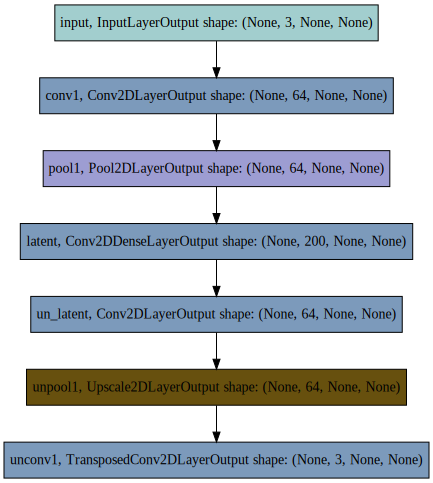

In [40]:
from IPython.display import SVG
draw_to_file(layers.get_all_layers(l_decoder_out), "unsupervised_reverse_generation.svg")
SVG("unsupervised_reverse_generation.svg")

In [41]:
layers_by_name = OrderedDict()


all_layers = (
    layers.get_all_layers(model.x_to_z.output_layers[0]) +
    layers.get_all_layers(model.z_to_x.output_layers[0])
)

for l in all_layers:
    if l.name is not None:
        layers_by_name[l.name] = l
print(layers_by_name.keys())

['input', 'conv1', 'pool1', 'latent', 'un_latent', 'unpool1', 'unconv1']


## Define the capsule object

The Capsule object combines all the components:

    - The model
    - The training algorithm
    - The loss function

In [42]:
input_variables = OrderedDict()
input_variables["input_image"] = dict(tensor_type=T.tensor4)

In [43]:
def loss_function(model, tensors, noise=False):
    input_image = tensors["input_image"]    
    input_image_old = input_image
    #noisify
    if noise is True:
        input_image = input_image #* (rng.uniform(size=input_image.shape) <= 0.5)
        input_image = input_image + rng.normal(std=0.1, size=input_image.shape)
    output = get_output(model, input_image)    
    recons = ((input_image_old - output) ** 2).sum(axis=(1, 2, 3)).mean()
    return recons

def get_latent(model, input_image):
    z, = model.x_to_z.get_output(input_image)
    return z

def get_output(model, input_image):
    z = get_latent(model, input_image)
    o, = model.z_to_x.get_output(z)
    return o

def get_output_from_latent(model, latent):
    o, = model.z_to_x.get_output(latent)
    return o

def get_loss(model, input_image):
    return loss_function(model, {"input_image": input_image}, noise=True)

def get_loss_deterministic(model, input_image):
    return loss_function(model, {"input_image": input_image}, noise=False)

functions = dict(
    get_output=dict(
        get_output=get_output,
        params=["input_image"]
    ),   
    get_latent=dict(
        get_output=get_latent,
        params=["input_image"]
    ),
    get_loss=dict(
        get_output=get_loss,
        params=["input_image"]
    ),
    get_loss_deterministic=dict(
        get_output=get_loss_deterministic,
        params=["input_image"]
    )
  
)

class MyBatchOptimizer(BatchOptimizer):
    # called for each epoch during training
    def iter_update(self, epoch, nb_batches, iter_update_batch):
        status = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        nb = 200
        status["train_loss"] = self.model.get_loss_deterministic(X[train][0:nb])
        status["test_loss"] = self.model.get_loss_deterministic(X[test][0:nb])
        return status

In [44]:
batch_optimizer = MyBatchOptimizer(
    verbose=1,
    max_nb_epochs=100,
    batch_size=100,
    optimization_procedure=(updates.rmsprop, 
                            {"learning_rate": 0.0001})
)

In [45]:
capsule = Capsule(
    input_variables, 
    model,
    loss_function,
    functions=functions,
    batch_optimizer=batch_optimizer,
)

In [46]:
!nvidia-smi

Thu Oct 15 14:10:30 2015       
+------------------------------------------------------+                       
| NVIDIA-SMI 5.319.37   Driver Version: 319.37         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K20m          Off  | 0000:05:00.0     Off |                    0 |
| N/A   45C    P0    46W / 225W |      678MB /  4799MB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K20m          Off  | 0000:42:00.0     Off |                    0 |
| N/A   43C    P8    26W / 225W |       11MB /  4799MB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [47]:
print(X.shape)

(2000, 3, 28, 28)


In [48]:
capsule.fit(input_image=X[train])

  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      0     185.096       260.729       130.279      131.339
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      1     6.16982       122.235       114.269      114.364
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      2     4.92198       112.884       106.998      107.576
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      3     4.54187       107.847       102.754      103.428
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      4     4.48746       104.171       98.8636      100.087
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ---

## checking performance

In [49]:
input_images = X
input_images = input_images[np.random.randint(0, input_images.shape[0], size=150)]
output_images = capsule.get_output(input_images)

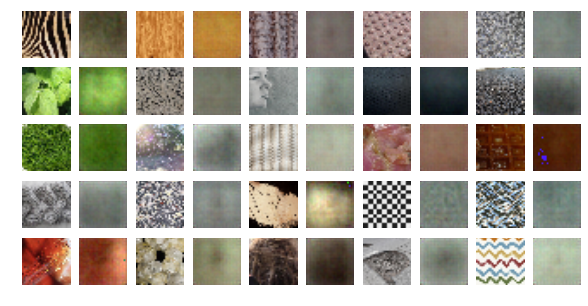

In [50]:
input_images_ = input_images.transpose((0, 2, 3, 1))
output_images_ = output_images.transpose((0, 2, 3, 1))
if input_images_.shape[-1] == 1:
    input_images_ = input_images_[:, :, :, 0]
    
if output_images_.shape[-1] == 1:
    output_images_ = output_images_[:, :, :, 0]
    
fig = plt.figure(figsize=(10, 10))
n = 5
gridw, gridh = n*2, n*2
k = 1
ind = 0
for i in range(n):
    for j in range(n):
        plt.subplot(gridw, gridh, k)
        plt.axis('off')
        plt.imshow(input_images_[ind], cmap="gray")
        k += 1
        plt.subplot(gridw, gridh, k)
        plt.axis('off')
        plt.imshow(output_images_[ind], cmap="gray")
        k += 1
        ind += 1
plt.show()

## Apply blending

In [86]:
#!wget http://i.imgur.com/2HVJF0t.gif --output-document=image.gif
#!wget http://www.mescoloriages.com/coloriages/animaux/cheval/cheval%201/images/chevaux_1_015.gif --output-document=image.gif

!wget http://i.imgur.com/iqZBF6A.jpg --output-document=image.jpg # im1
#!wget http://jmg.j.m.pic.centerblog.net/it3ahbzg.jpg --output-document=image.jpg #im2
#!wget http://jmg.j.m.pic.centerblog.net/c4j703bp.jpg --output-document=image.jpg #im3
#!wget http://www.freelargeimages.com/wp-content/uploads/2014/12/Landscape_01.jpg --output-document=image.jpg # im4

#!wget http://www.mescoloriages.com/coloriages/animaux/cheval/chevaux%205/images/chevaux_5_008.gif --output-document=image.gif
#!wget http://www2.mes-coloriages-preferes.biz/colorino/Images/Large/Animaux-Cheval-3756.png --output-document=image.gif
#!wget https://sustainability.uic.edu/files/2013/11/Tree.jpg --output-document=image.jpg --no-check-certificate
#!wget http://www.vbctulsa.com/wordpress/wp-content/uploads/2015/02/wrackthetree.jpg --output-document=image.jpg

--2015-10-15 14:19:05--  http://i.imgur.com/iqZBF6A.jpg
Resolving i.imgur.com... 185.31.18.193
Connecting to i.imgur.com|185.31.18.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 727023 (710K) [image/jpeg]
Saving to: “image.jpg”

100%[======================================>] 727,023     --.-K/s   in 0.1s    

2015-10-15 14:19:05 (6.39 MB/s) - “image.jpg” saved [727023/727023]



In [87]:
from skimage.io import imread
from skimage.color import gray2rgb
from skimage.transform import resize
image = (imread("image.jpg"))
print(image.shape)
image = resize(image, (512, 512))
#image = image[:, :, 0] # RGB?
#print(image)
image = 1 - image
if len(image.shape) == 2:
    image = image[:, :, None] * np.ones((1, 1, nb_colors))
print(image.shape)

(1836, 3264, 3)
(512, 512, 3)


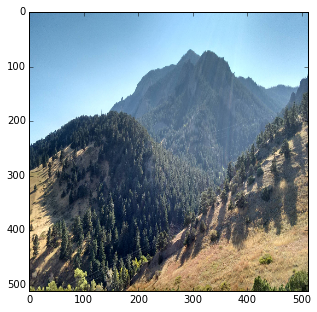

In [88]:
fig = plt.figure(figsize=(5, 5))
im = image[:, :, 0] if nb_colors == 1 else image
plt.imshow(1-im, cmap="gray")

(1, 3, 512, 512)


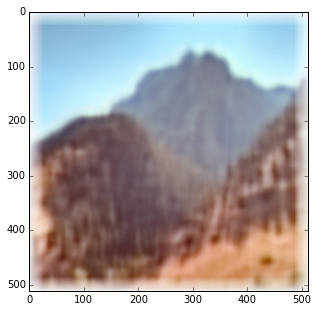

In [89]:
image_ = (image.transpose((2, 0, 1)).astype(np.float32))[None, :, :, :].copy()
print(image_.shape)
for i in range(1):
    image_ = capsule.get_output(image_)
image__ = image_.transpose((0, 2, 3, 1))

im = image__[0, :, :, 0] if nb_colors == 1 else image__[0]

im = (im - im.min()) / (im.max() - im.min())
fig = plt.figure(figsize=(5, 5))
plt.imshow(1-im, cmap="gray")

## weights

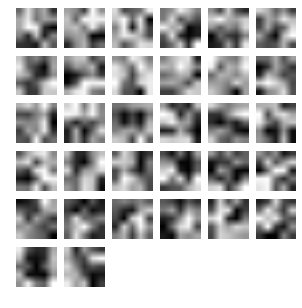

In [51]:
from lasagnekit.misc.plot_weights import grid_plot
for l in all_layers:
    print(l)
fig = plt.figure(figsize=(5, 5))
V = all_layers[1].W.get_value()
V = V.transpose((0, 2, 3, 1))
min_val = (V.min(axis=(0, 1, 2)))
max_val = (V.max(axis=(0, 1, 2)))
V = (V - min_val) / (max_val - min_val)
#V = (V - V.min()) / (V.max() - V.min())
V_ = V[:, :, :, 0] if V.shape[-1] == 1 else V
grid_plot(V_, imshow_options={"cmap": "gray"})